# Load packages

In [35]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import gridspec
import matplotlib
import cartopy as cart
import statistics
from scipy import stats

ModuleNotFoundError: No module named 'seaborn'

# Load data

In [2]:
omega_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_wap_37model_piControl_2x2_last250.nc')

land_mask = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_landmask_31model.nc')

tas_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_tas_piControl_2x2_48mod_last250.nc')

ts_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_ts_39model_piControl_2x2_last250.nc')

In [3]:
models = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2',
          'CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2','CIESM','CMCC-CM2-SR5','CMCC-ESM2','E3SM-1-0','EC-Earth3',
          'EC-Earth3-AerChem','EC-Earth3-CC','EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4','GFDL-ESM4',
          'GISS-E2-1-G','INM-CM4-8','INM-CM5-0','IPSL-CM5A2-INCA','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0',
          'NorCPM1','NorESM2-LM','NorESM2-MM','SAM0-UNICON','TaiESM1']

In [4]:
mask = land_mask.mean('name')

# Process data

# TAS Bony Decomposition

In [6]:
omega_cont_mean = omega_cont.sel(name=models).isel(time=slice(len(omega_cont.time)-(30*12),
                                             len(omega_cont.time))).sel(lat=slice(-30,30)).mean('time').mean('name')

#omega_cont_mean = omega_cont.sel(lat=slice(-30,30)).mean('time').mean('name')

In [6]:
tas_cont_rolling = tas_cont.sel(name=models).rolling(time=120, center=True).mean('time')
tas_cont_std = tas_cont_rolling.std('time')
tas_cont_var = tas_cont_std.mean('name').sel(lat=slice(-30,30))

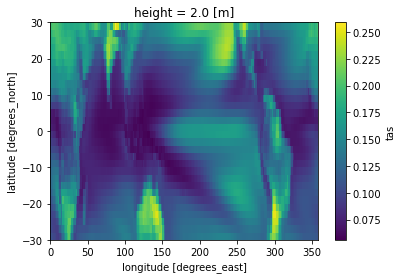

In [8]:
tas_cont_var.plot()

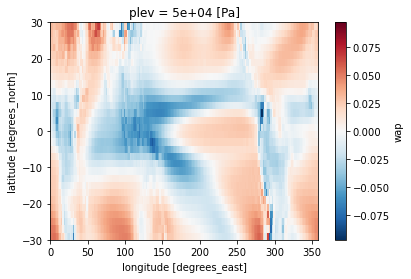

In [12]:
omega_cont_mean.plot()

In [7]:
bin_edges_tas = np.arange(-0.08,0.07,0.01)
print(bin_edges_tas)

[-8.00000000e-02 -7.00000000e-02 -6.00000000e-02 -5.00000000e-02
 -4.00000000e-02 -3.00000000e-02 -2.00000000e-02 -1.00000000e-02
 -4.16333634e-17  1.00000000e-02  2.00000000e-02  3.00000000e-02
  4.00000000e-02  5.00000000e-02  6.00000000e-02  7.00000000e-02]


In [9]:
omega_cont_mean_ds = omega_cont_mean.to_dataset()

In [10]:
omega_cont_mean_ds['tas_var'] = tas_cont_var
omega_cont_mean_ds

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 179)
Coordinates:
    plev     float64 ...
  * lat      (lat) int64 -29 -27 -25 -23 -21 -19 -17 ... 17 19 21 23 25 27 29
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    height   float64 ...
Data variables:
    wap      (lat, lon) float64 0.05193 0.05308 0.05382 ... 0.01761 0.02706
    tas_var  (lat, lon) float64 0.1056 0.1027 0.1004 ... 0.1831 0.1891 0.1974

In [11]:
omega_cont_mean_stack_tas = omega_cont_mean_ds.stack(z=('lat','lon'))

In [12]:
omega_cont_mean_stack_tas['tags_tas'] = pd.cut(omega_cont_mean_stack_tas['wap'], bins=bin_edges_tas, 
                                               labels=bin_edges_tas[:-1])

In [13]:
omega_tas_stats = omega_cont_mean_stack_tas.groupby('tags_tas').groups

In [14]:
var_mean_binned = []
var_std_binned = []
for group in omega_tas_stats:
    tas_var_list = []
    for index in omega_tas_stats[group]:
        tas_var_list.append(omega_cont_mean_stack_tas.tas_var[index].item())
    print(statistics.mean(tas_var_list))
    var_mean_binned.append(np.mean(tas_var_list))
    var_std_binned.append(np.std(tas_var_list))

0.11401790407711926
0.06810047303667024
0.06928038215631034
0.08120630921800943
0.08768835371940845
0.09854348120139139
0.11226226991097402
0.12162964098138411
0.1281480820718075
0.13480219523565393
0.14494994427471025
0.14569435846410078
0.13947753000937138
0.1459713152552719
0.20539798178403212


In [16]:
omega_tas_stats.keys()

dict_keys([-0.08, -0.07, -0.06000000000000001, -0.05000000000000002, -0.04000000000000002, -0.030000000000000027, -0.02000000000000003, -0.010000000000000037, -4.163336342344337e-17, 0.009999999999999953, 0.01999999999999995, 0.029999999999999943, 0.03999999999999994, 0.04999999999999995, 0.05999999999999993])

(-0.09, 0.07)

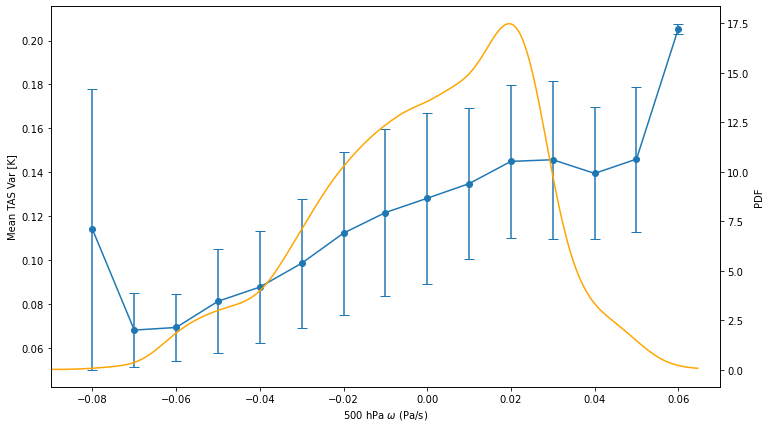

In [22]:
# Last 30 years of omega
plt.rcParams['figure.figsize'] = [12, 7]
fig, ax1 = plt.subplots()
ax1.errorbar(omega_tas_stats.keys(), var_mean_binned, var_std_binned, capsize=5)
ax1.scatter(omega_tas_stats.keys(), var_mean_binned)
ax1.set_ylabel('Mean TAS Var [K]')
#ax1.set_ylim(0.025,0.225)

ax2 = ax1.twinx()
gkde_tas = stats.gaussian_kde(omega_cont_mean_stack_tas['wap'])
tas_pdf = gkde_tas.evaluate(np.linspace(omega_cont_mean_stack_tas['wap'].min(), omega_cont_mean_stack_tas['wap'].max(),
                                       200))
#ax2.hist(omega_cont_mean_stack_tas['wap'], bin_edges_tas, density=True)
ax2.plot(np.linspace(omega_cont_mean_stack_tas['wap'].min(), omega_cont_mean_stack_tas['wap'].max(),
                                       200), tas_pdf, color='orange')
ax2.set_ylabel('PDF')

ax1.set_xlabel(r'500 hPa $\omega$ (Pa/s)')
plt.xlim(-0.09,0.07)

# TS Bony Decomposition

In [7]:
omega_cont_trunc = omega_cont_mean.where(mask<50)

In [8]:
ts_cont_rolling = ts_cont.sel(name=models).rolling(time=120, center=True).mean('time')
ts_cont_std = ts_cont_rolling.std('time')
ts_cont_var = ts_cont_std.mean('name').sel(lat=slice(-30,30)).where(mask<50)

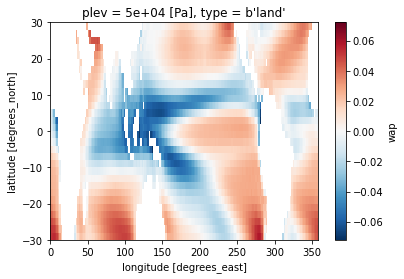

In [16]:
omega_cont_trunc.plot()

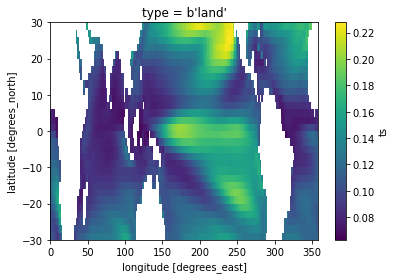

In [15]:
# Mask < 50
ts_cont_var.plot()

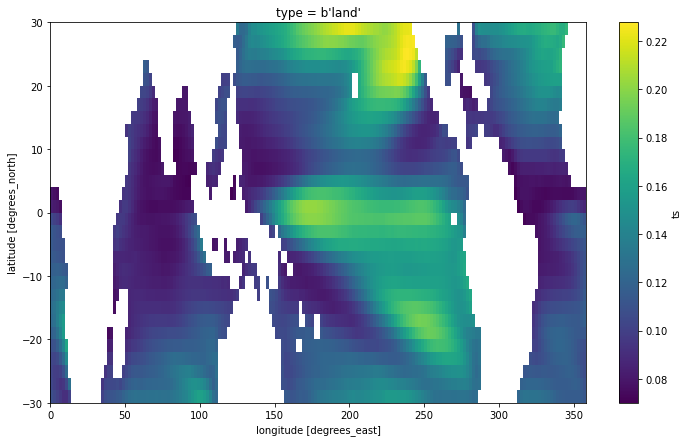

In [20]:
# Mask < 2
ts_cont_var.plot()

In [9]:
omega_cont_trunc_ds = omega_cont_trunc.to_dataset()

In [10]:
omega_cont_trunc_ds['ts_var'] = ts_cont_var

In [11]:
omega_cont_trunc_stack = omega_cont_trunc_ds.stack(z=('lat','lon'))

In [99]:
bin_edges = np.arange(-0.08,0.11,0.03)
print(bin_edges)

[-0.08 -0.05 -0.02  0.01  0.04  0.07  0.1 ]


In [100]:
omega_cont_trunc_stack['tags_ts'] = pd.cut(omega_cont_trunc_stack['wap'], bins=bin_edges, labels=bin_edges[:-1])

In [101]:
omega_ts_stats = omega_cont_trunc_stack.groupby('tags_ts').groups

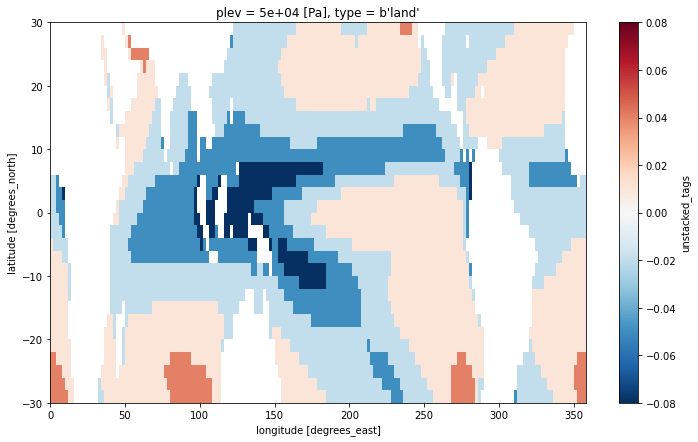

In [104]:
# Looking at the bins on a map
unstacked_omega = omega_cont_trunc_stack.unstack()
unstacked_omega['unstacked_tags'] = (('lat','lon'),np.reshape(omega_cont_trunc_stack['tags_ts'].values, (-1,179)))
unstacked_omega['unstacked_tags'].plot()

In [73]:
omega_cont_trunc_stack.unstack()

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 179, tags_ts: 5370)
Coordinates:
  * lat      (lat) int64 -29 -27 -25 -23 -21 -19 -17 ... 17 19 21 23 25 27 29
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    plev     float64 5e+04
    type     |S4 b'land'
  * tags_ts  (tags_ts) float64 0.05 0.05 0.05 0.05 0.04 ... 0.02 nan nan nan nan
Data variables:
    wap      (lat, lon) float64 0.05193 0.05308 0.05382 0.05279 ... nan nan nan
    ts_var   (lat, lon) float64 0.1077 0.104 0.1006 0.0961 ... nan nan nan nan

In [58]:
omega_cont_trunc_stack

<xarray.Dataset>
Dimensions:  (z: 5370, tags_ts: 5370)
Coordinates:
    plev     float64 5e+04
    type     |S4 b'land'
  * z        (z) object MultiIndex
  * lat      (z) int64 -29 -29 -29 -29 -29 -29 -29 -29 ... 29 29 29 29 29 29 29
  * lon      (z) int64 1 3 5 7 9 11 13 15 17 ... 343 345 347 349 351 353 355 357
  * tags_ts  (tags_ts) float64 0.05 0.05 0.05 0.05 0.04 ... 0.02 nan nan nan nan
Data variables:
    wap      (z) float64 0.05193 0.05308 0.05382 0.05279 ... nan nan nan nan
    ts_var   (z) float64 0.1077 0.104 0.1006 0.0961 0.09098 ... nan nan nan nan

In [102]:
for key in omega_ts_stats.keys():
    print(key)

-0.08
-0.05
-0.020000000000000004
0.009999999999999995
0.039999999999999994


In [103]:
var_mean_binned_ts = []
var_std_binned_ts = []
for group in omega_ts_stats:
    ts_var_list = []
    for index in omega_ts_stats[group]:
        ts_var_list.append(omega_cont_trunc_stack.ts_var[index].item())
    print(np.nanmean(ts_var_list))
    var_mean_binned_ts.append(np.nanmean(ts_var_list))
    var_std_binned_ts.append(np.nanstd(ts_var_list))

0.11588985818915616
0.11998513271517441
0.11591752502592281
0.11188179271536375
0.1253054760963655


(-0.09, 0.06)

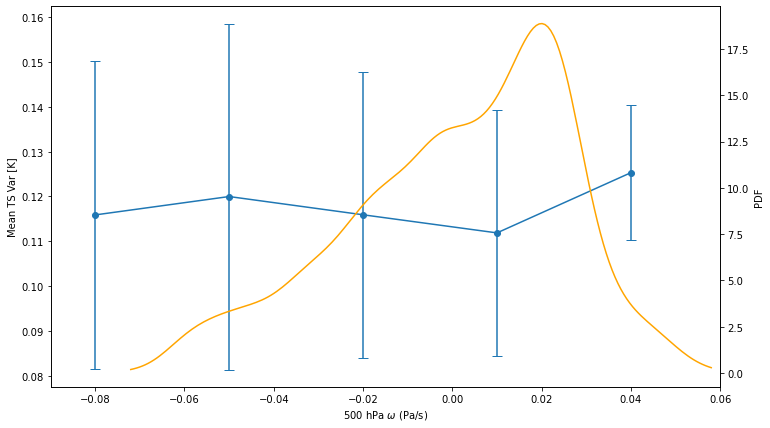

In [97]:
# Edits
plt.rcParams['figure.figsize'] = [12, 7]
fig, ax1 = plt.subplots()
ax1.errorbar(omega_ts_stats.keys(), var_mean_binned_ts, var_std_binned_ts, capsize=5)
ax1.scatter(omega_ts_stats.keys(), var_mean_binned_ts)
ax1.set_ylabel('Mean TS Var [K]')
#ax1.set_ylim(0.025,0.225)

ax2 = ax1.twinx()
gkde_ts = stats.gaussian_kde(omega_cont_trunc_stack['wap'][~np.isnan(omega_cont_trunc_stack['wap'])])
ts_pdf = gkde_ts.evaluate(np.linspace(omega_cont_trunc_stack['wap'].min(), omega_cont_trunc_stack['wap'].max(),
                                       200))
#ax2.hist(omega_cont_trunc_stack['wap'], bin_edges_ts, density=True)
ax2.plot(np.linspace(omega_cont_trunc_stack['wap'].min(), omega_cont_trunc_stack['wap'].max(),
                                       200), ts_pdf, color='orange')
ax2.set_ylabel('PDF')
ax1.set_xlabel(r'500 hPa $\omega$ (Pa/s)')
plt.xlim(-0.09,0.06)

(-0.09, 0.06)

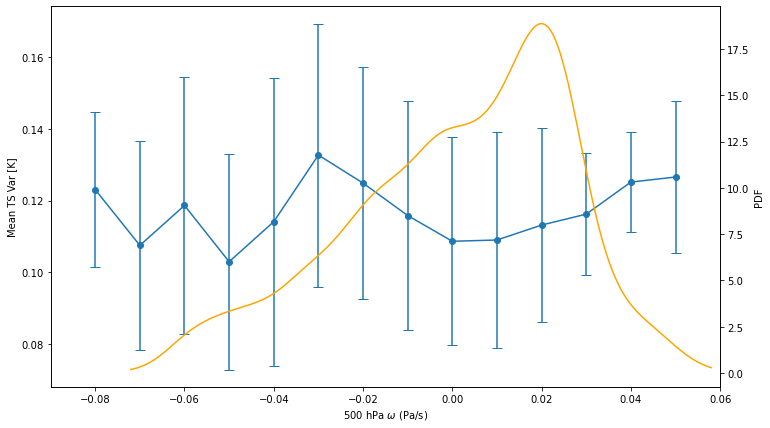

In [54]:
# orig
plt.rcParams['figure.figsize'] = [12, 7]
fig, ax1 = plt.subplots()
ax1.errorbar(omega_ts_stats.keys(), var_mean_binned_ts, var_std_binned_ts, capsize=5)
ax1.scatter(omega_ts_stats.keys(), var_mean_binned_ts)
ax1.set_ylabel('Mean TS Var [K]')
#ax1.set_ylim(0.025,0.225)

ax2 = ax1.twinx()
gkde_ts = stats.gaussian_kde(omega_cont_trunc_stack['wap'][~np.isnan(omega_cont_trunc_stack['wap'])])
ts_pdf = gkde_ts.evaluate(np.linspace(omega_cont_trunc_stack['wap'].min(), omega_cont_trunc_stack['wap'].max(),
                                       200))
#ax2.hist(omega_cont_trunc_stack['wap'], bin_edges_ts, density=True)
ax2.plot(np.linspace(omega_cont_trunc_stack['wap'].min(), omega_cont_trunc_stack['wap'].max(),
                                       200), ts_pdf, color='orange')
ax2.set_ylabel('PDF')
ax1.set_xlabel(r'500 hPa $\omega$ (Pa/s)')
plt.xlim(-0.09,0.06)

# -20 to 20

## TAS

In [55]:
omega_cont_mean_20 = omega_cont.sel(name=models).isel(time=slice(len(omega_cont.time)-(30*12),
                                             len(omega_cont.time))).sel(lat=slice(-20,20)).mean('time')

In [56]:
tas_cont_rolling = tas_cont.sel(name=models).rolling(time=120, center=True).mean('time')
tas_cont_std = tas_cont_rolling.std('time')
tas_cont_var_20 = tas_cont_std.mean('name').sel(lat=slice(-20,20))

In [69]:
bin_edges_tas = np.arange(-0.08,0.05,0.01)
print(bin_edges_tas)

[-8.00000000e-02 -7.00000000e-02 -6.00000000e-02 -5.00000000e-02
 -4.00000000e-02 -3.00000000e-02 -2.00000000e-02 -1.00000000e-02
 -4.16333634e-17  1.00000000e-02  2.00000000e-02  3.00000000e-02
  4.00000000e-02]


In [70]:
omega_cont_mean_20_ds = omega_cont_mean_20.mean('name').to_dataset()

In [71]:
omega_cont_mean_20_ds['tas_var'] = tas_cont_var_20

In [72]:
omega_cont_mean_stack_20 = omega_cont_mean_20_ds.stack(z=('lat','lon'))

In [73]:
omega_cont_mean_stack_20['tags_tas'] = pd.cut(omega_cont_mean_stack_20['wap'], bins=bin_edges_tas, 
                                               labels=bin_edges_tas[:-1])

In [74]:
omega_tas_stats_20 = omega_cont_mean_stack_20.groupby('tags_tas').groups

In [75]:
var_mean_binned_20 = []
var_std_binned_20 = []
for group in omega_tas_stats_20:
    tas_var_list = []
    for index in omega_tas_stats_20[group]:
        tas_var_list.append(omega_cont_mean_stack_20.tas_var[index].item())
    print(statistics.mean(tas_var_list))
    var_mean_binned_20.append(statistics.mean(tas_var_list))
    var_std_binned_20.append(statistics.stdev(tas_var_list))

0.07227329882235223
0.06532760367152372
0.06762708203981262
0.07805541190006106
0.08542799737979043
0.09355207294687437
0.10060855346524848
0.1090698438746515
0.11794012073773623
0.12710204273831222
0.13875426949575756
0.11931402272732526


(-0.09, 0.04)

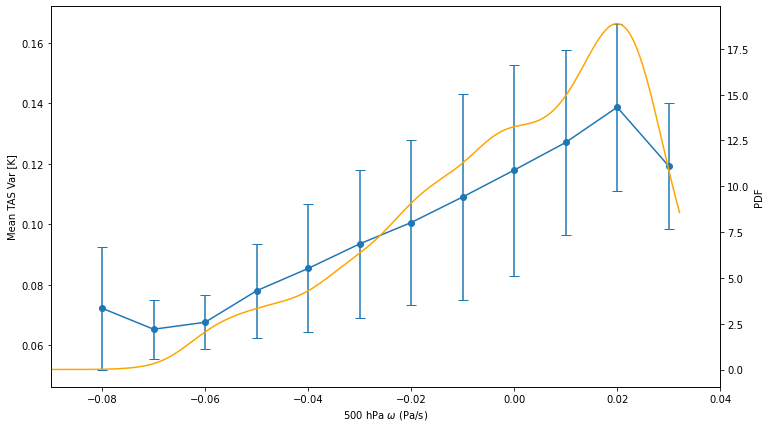

In [93]:
plt.rcParams['figure.figsize'] = [12, 7]
fig, ax1 = plt.subplots()
ax1.errorbar(omega_tas_stats_20.keys(), var_mean_binned_20, var_std_binned_20, capsize=5)
ax1.scatter(omega_tas_stats_20.keys(), var_mean_binned_20)
ax1.set_ylabel('Mean TAS Var [K]')
#ax1.set_ylim(0.025,0.225)

ax2 = ax1.twinx()
tas_pdf_20 = gkde_tas.evaluate(np.linspace(omega_cont_mean_stack_20['wap'].min(), omega_cont_mean_stack_20['wap'].max(),
                                       200))
#ax2.hist(omega_cont_mean_stack_20['wap'], bin_edges_tas, density=True)
ax2.plot(np.linspace(omega_cont_mean_stack_20['wap'].min(), omega_cont_mean_stack_20['wap'].max(),
                                       200), tas_pdf_20, color='orange')
ax2.set_ylabel('PDF')

ax1.set_xlabel(r'500 hPa $\omega$ (Pa/s)')
plt.xlim(-0.09,0.04)

In [68]:
omega_cont_mean_stack_20['wap'].min()

<xarray.DataArray 'wap' ()>
array(-0.0953979)
Coordinates:
    plev     float64 5e+04
    height   float64 2.0

## TS

In [81]:
ts_cont_rolling = ts_cont.sel(name=models).rolling(time=120, center=True).mean('time')
ts_cont_std = ts_cont_rolling.std('time')
ts_cont_var_20 = ts_cont_std.mean('name').sel(lat=slice(-20,20)).where(mask<50)

In [82]:
bin_edges_ts = np.arange(-0.07,0.04,0.01)
print(bin_edges_ts)

[-0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03  0.04]


In [84]:
omega_cont_trunc_20 = omega_cont_mean_20.where(mask<50).mean('name')
omega_cont_trunc_20_ds = omega_cont_trunc_20.to_dataset()

In [85]:
omega_cont_trunc_20_ds['ts_var'] = ts_cont_var_20

In [86]:
omega_cont_trunc_stack_20 = omega_cont_trunc_20_ds.stack(z=('lat','lon'))

In [87]:
omega_cont_trunc_stack_20['tags_ts'] = pd.cut(omega_cont_trunc_stack_20['wap'], bins=bin_edges_ts, 
                                               labels=bin_edges_ts[:-1])

In [88]:
omega_ts_stats_20 = omega_cont_trunc_stack_20.groupby('tags_ts').groups

In [89]:
var_mean_binned_ts_20 = []
var_std_binned_ts_20 = []
for group in omega_ts_stats_20:
    ts_var_list = []
    for index in omega_ts_stats_20[group]:
        ts_var_list.append(omega_cont_trunc_stack_20.ts_var[index].item())
    print(np.nanmean(ts_var_list))
    var_mean_binned_ts_20.append(np.nanmean(ts_var_list))
    var_std_binned_ts_20.append(np.nanstd(ts_var_list))

0.12343493305640903
0.11882914434621014
0.13424891137385467
0.11627721672436979
0.11624597614210536
0.11365315255357984
0.11314761501058655
0.107135658336045
0.10858633618003509
0.11349995981026223
0.1464139681985586


(-0.08, 0.04)

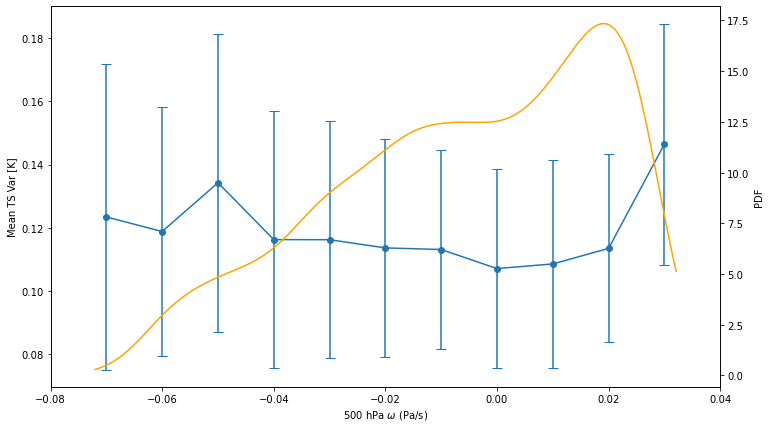

In [92]:
plt.rcParams['figure.figsize'] = [12, 7]
fig, ax1 = plt.subplots()
ax1.errorbar(omega_ts_stats_20.keys(), var_mean_binned_ts_20, var_std_binned_ts_20, capsize=5)
ax1.scatter(omega_ts_stats_20.keys(), var_mean_binned_ts_20)
ax1.set_ylabel('Mean TS Var [K]')
#ax1.set_ylim(0.025,0.225)

ax2 = ax1.twinx()
gkde_ts_20 = stats.gaussian_kde(omega_cont_trunc_stack_20['wap'][~np.isnan(omega_cont_trunc_stack_20['wap'])])
ts_pdf_20 = gkde_ts_20.evaluate(np.linspace(omega_cont_trunc_stack_20['wap'].min(), omega_cont_trunc_stack_20['wap'].max(),
                                       200))
#ax2.hist(omega_cont_trunc_stack_20['wap'], bin_edges_ts, density=True)
ax2.plot(np.linspace(omega_cont_trunc_stack_20['wap'].min(), omega_cont_trunc_stack_20['wap'].max(),
                                       200), ts_pdf_20, color='orange')
ax2.set_ylabel('PDF')

ax1.set_xlabel(r'500 hPa $\omega$ (Pa/s)')
plt.xlim(-0.08,0.04)